In [2]:
import os
import json
import cv2
import librosa
import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from warnings import filterwarnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

filterwarnings(action='ignore')

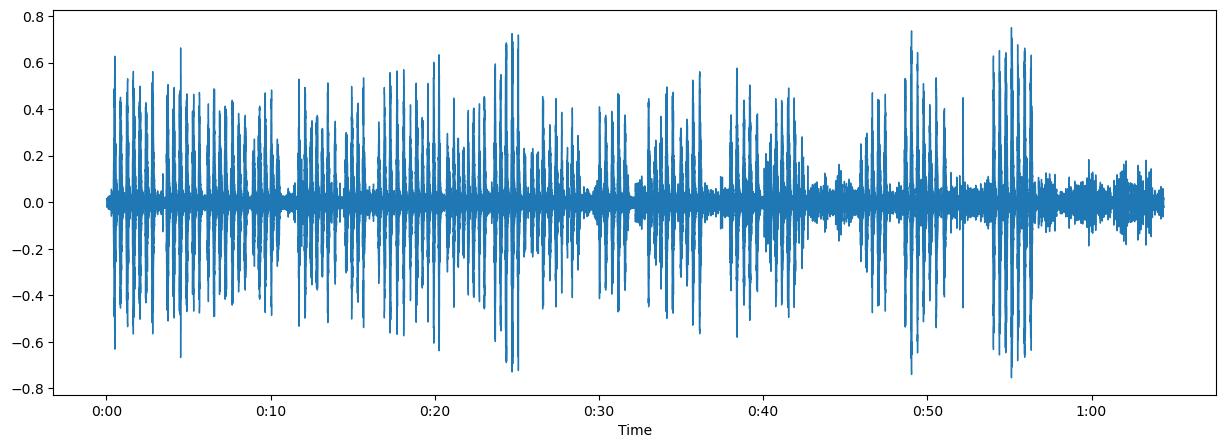

In [3]:
# Örnek ses inceleme

# Set Plot Size
plt.figure(figsize=(15,5))

# Load Audio File to extract Audio Data and Sample Rate
audio_data, sample_rate = librosa.load(path='C:/Users/Mustafa/Desktop/kus_sesi/asd/audio/amecro-amerikan kargası/XC51410.wav')
librosa.display.waveshow(y=audio_data, sr=sample_rate)

IPython.display.Audio(data='C:/Users/Mustafa/Desktop/kus_sesi/asd/audio/amecro-amerikan kargası/XC51410.wav')

In [4]:
# Ses otomatik olarak Mono Kanal [1 Boyutlu Sinyal] Verilerine dönüştürülecektir
audio_data

array([0.00596902, 0.00818823, 0.00447843, ..., 0.01218772, 0.00942496,
       0.        ], dtype=float32)

In [5]:
# Ses otomatik olarak 22050Hz hızına yeniden örneklenecektir (varsayılan sr=22050)
sample_rate

22050

**Mel-Frequency Cepstral Coefficients (MFCC)**

*MFCC, frekans ve zaman özelliklerine dayalı olarak sesten özelliklerin çıkarılmasına yardımcı olur. Bu özellikler sınıflandırmaya yardımcı olacaktır.*

- Pencere boyutu boyunca frekans dağılımını özetler.

- Böylece sesin 'frekans ve zaman özelliklerini' analiz eder.

- Bu sesli gösterimler, sınıflandırma için özelliklerin tanımlanmasına yardımcı olur.


In [5]:
# Örnek Ses Kontrolü
mfccs_features = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)

In [6]:
mfccs_features, mfccs_features.shape

(array([[-3.94313019e+02, -3.65624176e+02, -3.67185028e+02, ...,
         -3.36135834e+02, -3.36655579e+02, -3.75134644e+02],
        [ 9.00923157e+01,  8.71571808e+01,  8.22431793e+01, ...,
          2.96048279e+01,  3.52375412e+01,  3.80548325e+01],
        [ 1.56173496e+01,  1.61181068e+01,  1.20469475e+01, ...,
          4.50468674e+01,  4.30288544e+01,  3.51873817e+01],
        ...,
        [ 3.71390772e+00,  6.07597256e+00,  4.08224440e+00, ...,
         -5.23163319e+00, -3.74272561e+00, -7.61901093e+00],
        [-3.57796383e+00, -3.51931572e+00, -7.39422679e-01, ...,
          1.34982336e+00,  1.16290188e+00, -6.32955217e+00],
        [-1.74371219e+00, -2.88168311e-01,  1.71276724e+00, ...,
          6.12584591e-01, -9.26913738e-01, -6.13083363e+00]], dtype=float32),
 (40, 2773))

ses verilerinden hesaplanan Mel-Frekans Cepstral Katsayılarını (MFCC'ler) içerir. Şekil (40, 2773) şunu belirtir:
- 40 satır (40 MFCC özelliğini temsil eder)
- 2773 sütun (ses sinyalinin farklı çerçevelerini veya bölümlerini temsil eder).

In [7]:
# Örnek Ses Kontrolü
np.mean(mfccs_features, axis=1)    # eksen=1 satır bazında ortalama hesaplama anlamına gelir - şekil=(40,0) & eksen=0 sütun bazında ortalama hesaplama anlamına gelir - şekil=(2773,)

array([-2.4579341e+02,  4.0895317e+01, -3.2279106e+01, -5.7317615e+00,
       -5.9959726e+00,  3.3883949e+01, -1.1504466e+01, -6.7269835e+00,
       -1.2118723e+01,  1.8530584e+01,  2.9582498e+00,  5.5947299e+00,
       -2.3897266e+00, -1.0736701e+01, -2.7525828e+00,  2.4716518e+00,
        3.5525994e+00, -3.2718804e-01,  6.7564926e+00,  3.7592831e+00,
       -4.7374430e+00, -2.2043371e+00, -1.8376163e+00,  3.1043770e+00,
       -1.0615969e+00,  2.6900663e+00, -1.3018574e+00,  4.6827298e-01,
       -7.2429121e-01,  5.0542140e+00, -8.3444033e+00,  1.5041615e-01,
        1.2955961e-01,  2.2090724e+00, -2.4450011e+00, -1.3829652e+00,
       -1.6016493e+00,  2.6862595e+00, -3.3034451e+00, -1.6861207e+00],
      dtype=float32)

In [8]:
np.mean(mfccs_features, axis=1).shape


(40,)

### **Data Preprocessing**

In [6]:
# Sesleri Tensörlere dönüştürme

def audio_to_tensors(audio_file):
    # Sesten Sinyali ve Sample_Rate'i Çıkarılır.
    audio, sample_rate =librosa.load(audio_file)

    # MFCC Özelliklerini Çıkarın ve Birleştirilir.
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_features = np.mean(mfccs_features, axis=1)

    # Tensörlere Dönüştürülür.
    mfccs_tensors = tf.convert_to_tensor(mfccs_features, dtype=tf.float32)

    return mfccs_tensors

In [10]:
# Örnek Ses
audio_sample = 'C:/Users/Mustafa/Desktop/kus_sesi/asd/audio/amecro-amerikan kargası/XC51410.wav'
audio_to_tensors(audio_sample)

<tf.Tensor: shape=(40,), dtype=float32, numpy=
array([-2.4579341e+02,  4.0895317e+01, -3.2279106e+01, -5.7317615e+00,
       -5.9959726e+00,  3.3883949e+01, -1.1504466e+01, -6.7269835e+00,
       -1.2118723e+01,  1.8530584e+01,  2.9582498e+00,  5.5947299e+00,
       -2.3897266e+00, -1.0736701e+01, -2.7525828e+00,  2.4716518e+00,
        3.5525994e+00, -3.2718804e-01,  6.7564926e+00,  3.7592831e+00,
       -4.7374430e+00, -2.2043371e+00, -1.8376163e+00,  3.1043770e+00,
       -1.0615969e+00,  2.6900663e+00, -1.3018574e+00,  4.6827298e-01,
       -7.2429121e-01,  5.0542140e+00, -8.3444033e+00,  1.5041615e-01,
        1.2955961e-01,  2.2090724e+00, -2.4450011e+00, -1.3829652e+00,
       -1.6016493e+00,  2.6862595e+00, -3.3034451e+00, -1.6861207e+00],
      dtype=float32)>

In [7]:
# Ses Dosyalarından Özellikleri Çıkar

directory = 'C:/Users/Mustafa/Desktop/kus_sesi/asd/audio'

extracted_features = []

# Toplam dosya sayısını say
total_files = sum(len(files) for _, _, files in os.walk(directory))

with tqdm(total=total_files, desc='Processing files') as pbar:

  for target_class in os.listdir(directory):                               # Dizindeki Tüm Hedef Klasör Adlarının Listesi

      target_class_path = os.path.join(directory, target_class)            # Dizinde Hedef Klasör Yolu Oluşturun

      for audio_file in os.listdir(target_class_path):                     # Hedef Klasördeki Tüm Ses Dosyalarının Listesi

          audio_path = os.path.join(directory, target_class, audio_file)   # Dizindeki Hedef Klasörden Ses Dosyası Yolu Oluşturun

          features = audio_to_tensors(audio_path)                          # Özellikleri Ses Dosyasından Çıkarın

          extracted_features.append([features, target_class])              # Özellikleri ve Target_Class'ı Listeye Ekle

          pbar.update(1)                


Processing files: 100%|██████████| 951/951 [01:30<00:00, 10.54it/s]


In [8]:
extracted_features[0]

[<tf.Tensor: shape=(40,), dtype=float32, numpy=
 array([-161.23878   ,   57.046856  ,  -43.396065  ,  -15.460847  ,
         -10.440147  ,   41.797802  ,   -6.733766  ,  -14.589397  ,
         -21.392405  ,   -0.3529074 ,   -1.4773974 ,   -0.47861552,
           2.989904  ,   -6.3681126 ,  -14.670874  ,   -1.0297596 ,
          -7.198394  ,   -2.0391984 ,   -6.948815  ,   -4.5830116 ,
          -6.756442  ,    3.0749593 ,   -2.9219794 ,   -2.2921977 ,
          -2.083324  ,   -4.9170656 ,   -5.5014386 ,    1.168711  ,
          -6.41854   ,   -3.807455  ,   -2.0763237 ,   -1.462417  ,
          -4.3486667 ,   -1.4557004 ,   -2.990523  ,   -0.20595476,
          -5.365595  ,    0.8317127 ,   -4.459741  ,    0.53852093],
       dtype=float32)>,
 'amecro-amerikan kargası']

In [10]:
len(extracted_features)

951

In [13]:
# Sınıf Etiketleriyle Çıkartılan Özelliklerden DataFrame Oluşturma

features_df = pd.DataFrame(extracted_features, columns=['features', 'class'])
features_df

features  \
0    (tf.Tensor(-161.23878, shape=(), dtype=float32...   
1    (tf.Tensor(-360.28217, shape=(), dtype=float32...   
2    (tf.Tensor(-200.21054, shape=(), dtype=float32...   
3    (tf.Tensor(-295.60507, shape=(), dtype=float32...   
4    (tf.Tensor(-243.4587, shape=(), dtype=float32)...   
..                                                 ...   
946  (tf.Tensor(-421.5813, shape=(), dtype=float32)...   
947  (tf.Tensor(-535.6071, shape=(), dtype=float32)...   
948  (tf.Tensor(-459.08292, shape=(), dtype=float32...   
949  (tf.Tensor(-438.67337, shape=(), dtype=float32...   
950  (tf.Tensor(-495.99765, shape=(), dtype=float32...   

                         class  
0      amecro-amerikan kargası  
1      amecro-amerikan kargası  
2      amecro-amerikan kargası  
3      amecro-amerikan kargası  
4      amecro-amerikan kargası  
..                         ...  
946  spotow-Yeni dünya serçesi  
947  spotow-Yeni dünya serçesi  
948  spotow-Yeni dünya serçesi  
949  spotow-Yeni dünya serçesi  
950  spotow-Yeni dünya serçesi  

[951 rows x 2 columns]

In [14]:
# LabelEncoder kullanarak Sınıf Etiketlerini Kodlama

target_encoding = LabelEncoder().fit_transform(features_df['class'])
target_encoding

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

In [15]:
# DataFrame'e Kodlanmış Sınıf Etiketleri Sütunu Ekleme

features_df['target'] = target_encoding.tolist()
features_df

features  \
0    (tf.Tensor(-161.23878, shape=(), dtype=float32...   
1    (tf.Tensor(-360.28217, shape=(), dtype=float32...   
2    (tf.Tensor(-200.21054, shape=(), dtype=float32...   
3    (tf.Tensor(-295.60507, shape=(), dtype=float32...   
4    (tf.Tensor(-243.4587, shape=(), dtype=float32)...   
..                                                 ...   
946  (tf.Tensor(-421.5813, shape=(), dtype=float32)...   
947  (tf.Tensor(-535.6071, shape=(), dtype=float32)...   
948  (tf.Tensor(-459.08292, shape=(), dtype=float32...   
949  (tf.Tensor(-438.67337, shape=(), dtype=float32...   
950  (tf.Tensor(-495.99765, shape=(), dtype=float32...   

                         class  target  
0      amecro-amerikan kargası       0  
1      amecro-amerikan kargası       0  
2      amecro-amerikan kargası       0  
3      amecro-amerikan kargası       0  
4      amecro-amerikan kargası       0  
..                         ...     ...  
946  spotow-Yeni dünya serçesi       9  
947  spotow-Yeni dünya serçesi       9  
948  spotow-Yeni dünya serçesi       9  
949  spotow-Yeni dünya serçesi       9  
950  spotow-Yeni dünya serçesi       9  

[951 rows x 3 columns]

In [16]:
# Gelecek Tahmini için Sınıf ve Hedef sütunlarına dayalı Sözlük oluşturma

prediction_dict = features_df.set_index('target')['class'].to_dict()
prediction_dict

{0: 'amecro-amerikan kargası',
 1: 'barswa-kar kırlangıcı',
 2: 'brdowl-Çizgili baykuş',
 3: 'easpho-Fibi Tiranı',
 4: 'greegr-büyük akbalıkçıl',
 5: 'greyel-büyük sarıbacak',
 6: 'lotduc -tel kuyruklu ördek',
 7: 'norcar-kırmızı kardinal',
 8: 'sora -ardıç kuşu',
 9: 'spotow-Yeni dünya serçesi'}

In [17]:
# JSON Dosyasına Kaydet

with open(file='C:/Users/Mustafa/Desktop/kus_sesi/prediction.json', mode='w') as f:
    json.dump(prediction_dict, f)

In [18]:
# Prediction_Dictionary Dosyasını Oku

with open(file='C:/Users/Mustafa/Desktop/kus_sesi/prediction.json', mode='r') as f:
    prediction_dict = json.load(f)
prediction_dict

{'0': 'amecro-amerikan kargası',
 '1': 'barswa-kar kırlangıcı',
 '2': 'brdowl-Çizgili baykuş',
 '3': 'easpho-Fibi Tiranı',
 '4': 'greegr-büyük akbalıkçıl',
 '5': 'greyel-büyük sarıbacak',
 '6': 'lotduc -tel kuyruklu ördek',
 '7': 'norcar-kırmızı kardinal',
 '8': 'sora -ardıç kuşu',
 '9': 'spotow-Yeni dünya serçesi'}

In [19]:
# Özellikleri Listeye Dönüştürme
features = features_df['features'].tolist()
features

[<tf.Tensor: shape=(40,), dtype=float32, numpy=
 array([-161.23878   ,   57.046856  ,  -43.396065  ,  -15.460847  ,
         -10.440147  ,   41.797802  ,   -6.733766  ,  -14.589397  ,
         -21.392405  ,   -0.3529074 ,   -1.4773974 ,   -0.47861552,
           2.989904  ,   -6.3681126 ,  -14.670874  ,   -1.0297596 ,
          -7.198394  ,   -2.0391984 ,   -6.948815  ,   -4.5830116 ,
          -6.756442  ,    3.0749593 ,   -2.9219794 ,   -2.2921977 ,
          -2.083324  ,   -4.9170656 ,   -5.5014386 ,    1.168711  ,
          -6.41854   ,   -3.807455  ,   -2.0763237 ,   -1.462417  ,
          -4.3486667 ,   -1.4557004 ,   -2.990523  ,   -0.20595476,
          -5.365595  ,    0.8317127 ,   -4.459741  ,    0.53852093],
       dtype=float32)>,
 <tf.Tensor: shape=(40,), dtype=float32, numpy=
 array([-3.6028217e+02,  3.2209724e+01, -5.1718868e+01,  5.2244048e+00,
        -1.4457292e+01,  8.2931690e+00, -1.9385500e+01, -3.1563984e+01,
        -3.7662342e+01, -1.3042096e+01, -1.2732280e+01,

In [20]:
# Hedefleri Listelere Dönüştürme
target = features_df['target'].tolist()
print(target)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [21]:
# Özellikleri ve Hedefleri TensorFlow Tensörlerine Dönüştürme
features_tensor = tf.convert_to_tensor(features)
target_tensor = tf.convert_to_tensor(target)

In [22]:
features_tensor

<tf.Tensor: shape=(951, 40), dtype=float32, numpy=
array([[-1.6123878e+02,  5.7046856e+01, -4.3396065e+01, ...,
         8.3171272e-01, -4.4597411e+00,  5.3852093e-01],
       [-3.6028217e+02,  3.2209724e+01, -5.1718868e+01, ...,
         2.4265015e+00,  1.6506344e+00,  9.9202317e-01],
       [-2.0021054e+02,  1.3242099e+01, -8.2328323e+01, ...,
         1.8521470e+00, -6.4889675e-01,  1.2513201e+00],
       ...,
       [-4.5908292e+02, -1.5015356e+01, -6.9211936e+00, ...,
         1.2205792e-01, -2.0485430e+00,  1.5997913e+00],
       [-4.3867337e+02, -2.9822136e+01, -8.7608051e+00, ...,
         2.6069486e+00, -1.4829594e-01,  1.9524508e+00],
       [-4.9599765e+02,  5.3339317e+01, -1.4462198e+00, ...,
         3.2206681e+00,  4.1191933e-01,  3.3527377e+00]], dtype=float32)>

In [23]:
target_tensor

<tf.Tensor: shape=(951,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
     

In [24]:
# Tensörlerden TensorFlow Veri Kümesi Oluşturma
dataset = tf.data.Dataset.from_tensor_slices((features_tensor, target_tensor))
dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(40,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [25]:
# Veri kümesini gruplara ayır
batch_size = 32
dataset = dataset.batch(batch_size)
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [26]:
# Veri Kümesini Eğitim (%80), Doğrulama (%10) ve Test (%10) Kümelerine Bölmek için bir İşlev süreci tanımlayalım

def train_validation_test_split(dataset, train_size=0.8, validation_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):

    dataset_batch_count = len(dataset)                                                  
    train_batch_count = int(dataset_batch_count * train_size)                          
    validation_test_batch_count = int(dataset_batch_count * validation_size)            

    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_size)                             # Veri kümesini doldurduk daha iyi anlasın diye

    train_ds = dataset.take(train_batch_count)                                          
    validation_ds = dataset.skip(train_batch_count).take(validation_test_batch_count)  
    test_ds = dataset.skip(train_batch_count).skip(validation_test_batch_count)         

    return train_ds, validation_ds, test_ds

In [27]:
# Fonksiyonu Veri Kümesinde Uygula
train_ds, validation_ds, test_ds = train_validation_test_split(dataset)
len(train_ds), len(validation_ds), len(test_ds)

(24, 3, 3)

In [28]:
# Eğitim Veri Seti Yapısına ve Spesifikasyonlarına Genel Bakış
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [29]:
# Gelişmiş Performans için Optimize Edilmiş Veri Hattı Oluşturma

# Eğitim Veri Kümesi
train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

# Doğrulama Veri Kümesi
validation_ds = validation_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

# Test Veri Kümesi
test_ds = test_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

### **Model Building & Training**

In [30]:
# Giriş_şekli, Kanal ve Hedefin Parametrelerini tanımlayın

mfcc_features = 40    # Ses'ten çıkarılan özellikler
channel = 1           # Mono Kanal
target = 10        # Çıkış sınıfları

input_shape = (mfcc_features, channel)
input_shape

(40, 1)

In [46]:
model = keras.Sequential([

            # Giriş Katmanı
            keras.layers.Input(shape=input_shape),

            # Dönüşüm Katmanı
            keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool1D(pool_size=2, padding='same'),

            # Dönüşüm Katmanı
            keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool1D(pool_size=2, padding='same'),

            # Dönüşüm Katmanı
            keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool1D(pool_size=2, padding='same'),

            # Düzleştir ve 1 Boyutlu Vektöre Dönüştür
            keras.layers.Flatten(),

            #  Tam Bağlantılı Yoğun (Dense) Katman 
            keras.layers.Dense(units=512, activation='relu', kernel_regularizer=keras.regularizers.L2(l2=1e-2)),#Overfitting olmaması içiin ağırlık büyüklüklerinbi sınırladık
            keras.layers.Dropout(rate=0.3),

            # Tam Bağlantılı Yoğun (Dense) Katman
            keras.layers.Dense(units=512, activation='relu', kernel_regularizer=keras.regularizers.L2(l2=1e-2)),
            keras.layers.Dropout(rate=0.3),

            # Çıkış Katmanı
            keras.layers.Dense(units=target, activation='softmax')
        ])

model

<Sequential name=sequential_1, built=True>

In [32]:
# Model Özetini Görüntüle
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 38, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 17, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 9, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 7, 256)         │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,091,082 (4.16 MB)

 Trainable params: 1,089,802 (4.16 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [33]:
# Modeli Optimize Edici, Kayıp ve Metriklerle Derlemek

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model

<Sequential name=sequential, built=True>

In [34]:
# Training_Dataset ile Model Eğitimi ve Validation_Dataset ile Değerlendirilmesi

history = model.fit(train_ds,
                    batch_size=batch_size,
                    epochs=1000,
                    verbose=1,
                    validation_data = validation_ds)
history

Epoch 1/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.1014 - loss: 14.8857 - val_accuracy: 0.1458 - val_loss: 14.2266
Epoch 2/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0838 - loss: 15.1244 - val_accuracy: 0.0938 - val_loss: 14.2121
Epoch 3/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1025 - loss: 14.6261 - val_accuracy: 0.0833 - val_loss: 14.2000
Epoch 4/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1446 - loss: 14.4494 - val_accuracy: 0.0833 - val_loss: 14.1870
Epoch 5/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1321 - loss: 14.6090 - val_accuracy: 0.0938 - val_loss: 14.1681
Epoch 6/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1145 - loss: 14.4680 - val_accuracy: 0.1042 - val_loss: 14.1575
Epoch 7/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1692 - loss: 14.3593 - val_accuracy: 0.1354 - val_loss: 14.1294
Epoch 8/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1518 - loss: 14.3046 - 

In [35]:
# Test Veri Kümesinde Model Performansını Değerlendirme
model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9844 - loss: 0.2700 


[0.3505876958370209, 0.96875]

In [36]:
# Eğitim Geçmişinden Doğruluk Metriklerini Çıkarma
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Eğitim Geçmişinden Kayıp Metriklerini Çıkarma
loss = history.history['loss']
val_loss = history.history['val_loss']

In [38]:
# Modeli Kaydet
model.save('C:/Users/Mustafa/Desktop/kus_sesi/mdl.keras')

Text(0.5, 1.0, 'Training vs Validation Loss')

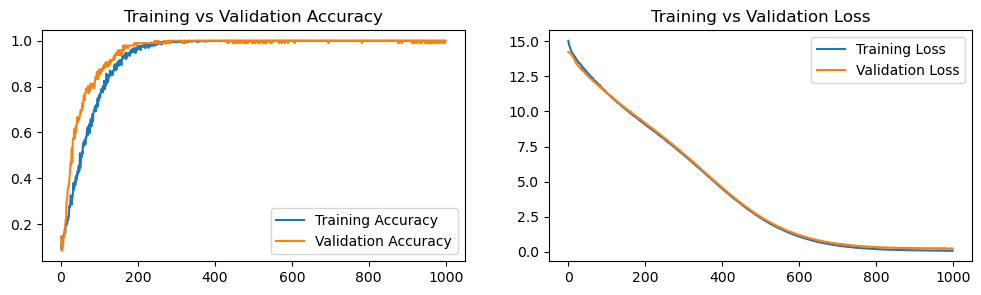

In [39]:
# Grafikleri kullanarak Keskinlik ve Kaybı görselleştirin

plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

### **Model Inference**

In [40]:
def prediction(audio_file):

 
    with open('C:/Users/Mustafa/Desktop/kus_sesi/prediction.json', mode='r') as f:
        prediction_dict = json.load(f)


    audio, sample_rate =librosa.load(audio_file)

    # MFCC Özellikleri Çıkarılır Birleştirilir
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_features = np.mean(mfccs_features, axis=1)

    # Conv1D için beklenen giriş şekliyle hem toplu hem de özellik boyutuyla eşleşecek şekilde MFCC özelliklerini yeniden şekillendirme
    mfccs_features = np.expand_dims(mfccs_features, axis=0)
    mfccs_features = np.expand_dims(mfccs_features, axis=2)

    # Tensörlere Dönüştür
    mfccs_tensors = tf.convert_to_tensor(mfccs_features, dtype=tf.float32)

    # Modeli ve Tahmini Yükle
    model = tf.keras.models.load_model('C:/Users/Mustafa/Desktop/kus_sesi/mdl.keras')
    prediction = model.predict(mfccs_tensors)

    # Maksimum Olasılık Değerini Bul
    target_label = np.argmax(prediction)

    # Prediction_dict'i kullanarak Target_Label Adını bul
    predicted_class = prediction_dict[str(target_label)]
    confidence = round(np.max(prediction)*100, 2)

    print(f'Predicted Class : {predicted_class}')
    print(f'Confident : {confidence}%')

In [42]:


with open('C:/Users/Mustafa/Desktop/kus_sesi/prediction.json', mode='r') as f:
    prediction_dict = json.load(f)
model = tf.keras.models.load_model('C:/Users/Mustafa/Desktop/kus_sesi/mdl.keras')

# Gerçek etiketleri ve tahminleri çıkarma
y_true = []
y_pred = []

for features, labels in test_ds:
    predictions = model.predict(features)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Test veri kümesindeki benzersiz sınıfları kontrol etme
unique_true_classes = set(y_true)
unique_pred_classes = set(y_pred)
all_unique_classes = sorted(unique_true_classes.union(unique_pred_classes))

# Sınıf adlarını unique sınıflara göre güncelleme
class_names = [prediction_dict[str(cls)] for cls in all_unique_classes]



# Performans metriklerini hesapla
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Doğruluk: {accuracy:.2f}')
print(f'Kesinlik: {precision:.2f}')
print(f'Duyarlılık: {recall:.2f}')
print(f'F1 Skoru: {f1:.2f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Doğruluk: 0.97
Kesinlik: 0.98
Duyarlılık: 0.97
F1 Skoru: 0.97


In [45]:
prediction('C:/Users/Mustafa/Desktop/kus_sesi/asd/audio/amecro-amerikan kargası/XC51410.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Predicted Class : amecro-amerikan kargası
Confident : 97.39%
